# Identifying Optimal Light Wavelength on the Plant Growth for Indoor Vertical Farm

## Team Members: Tamjid Azad, Christopher Vukmir, Abdul Rabbani Syed, Abdul Mannan Mohammed, Mohd Uddin

In [34]:
%matplotlib notebook
import os
import argparse
import matplotlib
import numpy as np
import pandas as pd
import skimage as ski
import pandas as pd
import imageio.v3 as iio
from datetime import datetime
import matplotlib.pyplot as plt
from plantcv import plantcv as pcv
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

### Constants

In [2]:
GLOBAL_PARENT_DIRECTORY = "./Images/"
GLOBAL_PLANTCV_MODE = False
GLOBAL_DEBUG_MODE = True
GLOBAL_OUTPUT_DIR = "img_output"
GLOBAL_RESULT_DIR = "data_output"
GLOBAL_PROPERTY_CSV_NAME = "properties.csv"

GLOBAL_DATSET_FIELD_NAMES = ["Name", 
                             "Date", 
                             "Red 1", 
                             "Green 1", 
                             "Blue 1", 
                             "Intensity 1", 
                             "Red 2", 
                             "Green 2", 
                             "Blue 2", 
                             "Intensity 2", 
                             "Area", 
                             ]

### Define class to hold farm options

In [3]:
class Farm_Dataset:
    
    dataset = []
    
    @classmethod
    def add_new_data_instance(self, path):
        # Get the name, images, and RGBI values from the specified path
        name = os.path.basename(os.path.normpath(path))
        farm_images = [image for image in os.listdir(path) if image.endswith(".jpg")]
        rgbi_values = pd.read_csv(path + '/' + GLOBAL_PROPERTY_CSV_NAME)
        
        # Error checking
        if name == None or farm_images == None or rgbi_values.empty:
            return
        
        self.dataset.append({"Instance Name" : name, "Images" : farm_images, "RGBI Values" : rgbi_values})
        
    @classmethod
    def print_rgb_images(self, farm_image_array, path):
        for img in farm_image_array:
               plot_image(path + img)
                
    @classmethod
    def print_rgb_values(self, farm_image_array, path):
        for img in farm_image_array:
            print(iio.imread(uri=path + img))
    
    @classmethod
    def plot_image(self, img):
        plant = iio.imread(uri=img)
    
        fig, ax = plt.subplots()
        plt.imshow(plant)
    
        return plant
        
    @classmethod
    def get_preprocessed_farm_data(self):
        preprocessed_farm_data_list = list()
        
        for instance in self.dataset:
            self.preprocess_single_instance(instance, preprocessed_farm_data_list)
        
        return preprocessed_farm_data_list
        
    @classmethod
    def preprocess_single_instance(self, instance, preprocessed_farm_data_list):
        preprocessed_farm_data = pd.DataFrame(columns=GLOBAL_DATSET_FIELD_NAMES)
        
        print("Processing  " + instance["Instance Name"]) if GLOBAL_DEBUG_MODE else None
        
        debug_index = 1
        for (img_path, date) in zip(instance["Images"], self.get_dates(instance["Images"])):
            print("Processing image " + str(debug_index) + " - " + str(date)) if GLOBAL_DEBUG_MODE else None
            
            img, path, filename = pcv.readimage(filename=GLOBAL_PARENT_DIRECTORY + instance["Instance Name"] + "/" + img_path)

            # convert the image to grayscale colorspace
            a = pcv.rgb2gray_lab(img, channel='a')

            # create the histogram of the grayscale image
            #hist = pcv.visualize.histogram(a)

            # threshold/segment plant material from the background 
            a_tresh = pcv.threshold.binary(gray_img=a, threshold=120, object_type='dark')

            # Fill in small objects
            a_fill_image = pcv.fill(bin_img=a_tresh, size=50)

            # count the number of white pixel which represent the plant material
            plantPixels = np.count_nonzero(a_fill_image)

            preprocessed_farm_data.loc[-1] = [instance["Instance Name"],
                                              date,
                                              instance["RGBI Values"].iloc[0]["R1"],
                                              instance["RGBI Values"].iloc[0]["G1"],
                                              instance["RGBI Values"].iloc[0]["B1"],
                                              instance["RGBI Values"].iloc[0]["I1"],
                                              instance["RGBI Values"].iloc[0]["R2"],
                                              instance["RGBI Values"].iloc[0]["G2"],
                                              instance["RGBI Values"].iloc[0]["B2"],
                                              instance["RGBI Values"].iloc[0]["I2"],
                                              round(1000*(plantPixels/11059200),2) 
                                              ]
            
            preprocessed_farm_data.index = preprocessed_farm_data.index + 1
            preprocessed_farm_data = preprocessed_farm_data.sort_index()
            
            debug_index = debug_index + 1
        #End for
        preprocessed_farm_data_list.append(preprocessed_farm_data)
    # End "preprocess_single_instance"
        
    @classmethod
    def get_dates(self, images):
        dates = list()
        for date in images:
            date_str = date.split(".jpg")[0]
            date_obj = datetime.strptime(date_str, '%m-%d-%Y_%H.%M.%S')
            dates.append(date_obj)
        return dates

### Initialization

In [4]:
farm_dataset = Farm_Dataset()
pcv.params.debug_outdir = GLOBAL_OUTPUT_DIR
pcv.params.debug = GLOBAL_PLANTCV_MODE

### Read Dataset

In [5]:
for pathname in os.listdir(GLOBAL_PARENT_DIRECTORY):
    if os.path.isdir(GLOBAL_PARENT_DIRECTORY + pathname):
        farm_dataset.add_new_data_instance(GLOBAL_PARENT_DIRECTORY + pathname)

### Analyze results using PlantCV

In [6]:
preprocessed_farm_data_list = farm_dataset.get_preprocessed_farm_data()

Processing  Farm 1 11_14_23
Processing image 1 - 2023-11-07 00:01:58
Processing image 2 - 2023-11-07 13:58:22
Processing image 3 - 2023-11-07 14:32:27
Processing image 4 - 2023-11-07 15:06:32
Processing image 5 - 2023-11-07 15:40:37
Processing image 6 - 2023-11-07 16:14:43
Processing image 7 - 2023-11-07 16:48:50
Processing image 8 - 2023-11-07 17:22:55
Processing image 9 - 2023-11-07 17:57:01
Processing image 10 - 2023-11-07 18:31:07
Processing image 11 - 2023-11-07 19:05:13
Processing image 12 - 2023-11-07 19:39:19
Processing image 13 - 2023-11-07 20:13:24
Processing image 14 - 2023-11-07 20:47:29
Processing image 15 - 2023-11-07 21:21:35
Processing image 16 - 2023-11-07 21:55:40
Processing image 17 - 2023-11-07 22:29:45
Processing image 18 - 2023-11-07 23:03:50
Processing image 19 - 2023-11-07 23:07:56
Processing image 20 - 2023-11-07 23:12:01
Processing image 21 - 2023-11-07 23:16:07
Processing image 22 - 2023-11-07 23:20:13
Processing image 23 - 2023-11-07 23:24:18
Processing imag

Processing image 33 - 2023-11-08 13:58:25
Processing image 34 - 2023-11-08 14:32:31
Processing image 35 - 2023-11-08 15:06:37
Processing image 36 - 2023-11-08 15:40:42
Processing image 37 - 2023-11-08 16:14:48
Processing image 38 - 2023-11-08 16:48:53
Processing image 39 - 2023-11-08 17:22:59
Processing image 40 - 2023-11-08 17:57:06
Processing image 41 - 2023-11-08 18:31:12
Processing image 42 - 2023-11-08 19:05:19
Processing image 43 - 2023-11-08 19:39:26
Processing image 44 - 2023-11-08 20:13:33
Processing image 45 - 2023-11-08 20:47:40
Processing image 46 - 2023-11-08 21:21:48
Processing image 47 - 2023-11-08 21:55:56
Processing image 48 - 2023-11-08 22:30:03
Processing image 49 - 2023-11-08 23:04:13
Processing image 50 - 2023-11-08 23:08:25
Processing image 51 - 2023-11-08 23:12:39
Processing image 52 - 2023-11-08 23:16:54
Processing image 53 - 2023-11-08 23:21:08
Processing image 54 - 2023-11-08 23:25:22
Processing image 55 - 2023-11-08 23:29:38
Processing image 56 - 2023-11-08 2

Processing image 66 - 2023-11-09 15:41:35
Processing image 67 - 2023-11-09 16:15:58
Processing image 68 - 2023-11-09 16:50:20
Processing image 69 - 2023-11-09 17:24:41
Processing image 70 - 2023-11-09 17:59:02
Processing image 71 - 2023-11-09 18:33:23
Processing image 72 - 2023-11-09 19:07:45
Processing image 73 - 2023-11-09 19:42:08
Processing image 74 - 2023-11-09 20:16:31
Processing image 75 - 2023-11-09 20:50:55
Processing image 76 - 2023-11-09 21:25:19
Processing image 77 - 2023-11-09 21:59:43
Processing image 78 - 2023-11-09 22:34:05
Processing image 79 - 2023-11-09 23:08:40
Processing image 80 - 2023-11-09 23:13:17
Processing image 81 - 2023-11-09 23:17:53
Processing image 82 - 2023-11-09 23:22:28
Processing image 83 - 2023-11-09 23:27:04
Processing image 84 - 2023-11-09 23:31:41
Processing image 85 - 2023-11-09 23:36:16
Processing image 86 - 2023-11-09 23:40:52
Processing image 87 - 2023-11-09 23:45:31
Processing image 88 - 2023-11-09 23:50:08
Processing image 89 - 2023-11-09 2

Processing image 8 - 2023-12-04 22:26:21
Processing image 9 - 2023-12-04 23:00:27
Processing image 10 - 2023-12-04 23:34:32
Processing image 11 - 2023-12-05 00:08:39
Processing image 12 - 2023-12-05 00:42:45
Processing image 13 - 2023-12-05 01:16:51
Processing image 14 - 2023-12-05 01:50:57
Processing image 15 - 2023-12-05 02:25:03
Processing image 16 - 2023-12-05 02:59:08
Processing image 17 - 2023-12-05 03:03:14
Processing image 18 - 2023-12-05 03:07:20
Processing image 19 - 2023-12-05 03:11:28
Processing image 20 - 2023-12-05 03:15:41
Processing image 21 - 2023-12-05 03:19:49
Processing image 22 - 2023-12-05 03:23:55
Processing image 23 - 2023-12-05 03:28:03
Processing image 24 - 2023-12-05 03:32:09
Processing image 25 - 2023-12-05 03:36:16
Processing image 26 - 2023-12-05 03:40:21
Processing image 27 - 2023-12-05 03:44:27
Processing image 28 - 2023-12-05 03:48:32
Processing image 29 - 2023-12-05 03:52:37
Processing image 30 - 2023-12-05 03:56:45
Processing image 31 - 2023-12-05 17:

In [7]:
if GLOBAL_DEBUG_MODE:
    for farm_data in preprocessed_farm_data_list:
        display(farm_data) 

,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 1 11_14_23,2023-11-09 23:58:54,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,305.68
1,Farm 1 11_14_23,2023-11-09 23:54:31,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,305.67
2,Farm 1 11_14_23,2023-11-09 23:50:08,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,304.63
3,Farm 1 11_14_23,2023-11-09 23:45:31,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,317.33
4,Farm 1 11_14_23,2023-11-09 23:40:52,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,321.02
...,...,...,...,...,...,...,...,...,...,...,...
85,Farm 1 11_14_23,2023-11-07 15:40:37,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,55.27
86,Farm 1 11_14_23,2023-11-07 15:06:32,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,53.85
87,Farm 1 11_14_23,2023-11-07 14:32:27,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,61.58
88,Farm 1 11_14_23,2023-11-07 13:58:22,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,63.06


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 1 12_06_23,2023-12-06 23:35:15,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,222.32
1,Farm 1 12_06_23,2023-12-06 23:01:08,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,219.95
2,Farm 1 12_06_23,2023-12-06 22:26:42,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,217.57
3,Farm 1 12_06_23,2023-12-06 21:52:32,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,210.25
4,Farm 1 12_06_23,2023-12-06 21:18:27,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,220.14
...,...,...,...,...,...,...,...,...,...,...,...
67,Farm 1 12_06_23,2023-12-04 20:09:53,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,30.99
68,Farm 1 12_06_23,2023-12-04 19:35:46,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,27.05
69,Farm 1 12_06_23,2023-12-04 19:01:41,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,24.08
70,Farm 1 12_06_23,2023-12-04 18:27:35,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,21.37


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 2 11_14_23,2023-11-09 23:58:54,7,42,108,165,153,28,42,102,414.31
1,Farm 2 11_14_23,2023-11-09 23:54:31,7,42,108,165,153,28,42,102,414.32
2,Farm 2 11_14_23,2023-11-09 23:50:08,7,42,108,165,153,28,42,102,414.76
3,Farm 2 11_14_23,2023-11-09 23:45:31,7,42,108,165,153,28,42,102,414.54
4,Farm 2 11_14_23,2023-11-09 23:40:52,7,42,108,165,153,28,42,102,413.70
...,...,...,...,...,...,...,...,...,...,...,...
85,Farm 2 11_14_23,2023-11-07 15:40:37,7,42,108,165,153,28,42,102,148.18
86,Farm 2 11_14_23,2023-11-07 15:06:32,7,42,108,165,153,28,42,102,135.80
87,Farm 2 11_14_23,2023-11-07 14:32:27,7,42,108,165,153,28,42,102,124.57
88,Farm 2 11_14_23,2023-11-07 13:58:22,7,42,108,165,153,28,42,102,126.12


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 2 12_06_23,2023-12-06 23:35:15,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,247.87
1,Farm 2 12_06_23,2023-12-06 23:01:08,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,245.99
2,Farm 2 12_06_23,2023-12-06 22:26:42,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,243.85
3,Farm 2 12_06_23,2023-12-06 21:52:32,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,241.24
4,Farm 2 12_06_23,2023-12-06 21:18:27,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,238.39
...,...,...,...,...,...,...,...,...,...,...,...
67,Farm 2 12_06_23,2023-12-04 20:09:53,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,37.37
68,Farm 2 12_06_23,2023-12-04 19:35:46,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,30.44
69,Farm 2 12_06_23,2023-12-04 19:01:41,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,41.15
70,Farm 2 12_06_23,2023-12-04 18:27:35,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,37.61


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 3 11_14_23,2023-11-09 23:58:54,22,67,162,200,232,40,43,134,228.88
1,Farm 3 11_14_23,2023-11-09 23:54:31,22,67,162,200,232,40,43,134,229.33
2,Farm 3 11_14_23,2023-11-09 23:50:08,22,67,162,200,232,40,43,134,228.34
3,Farm 3 11_14_23,2023-11-09 23:45:31,22,67,162,200,232,40,43,134,227.51
4,Farm 3 11_14_23,2023-11-09 23:40:52,22,67,162,200,232,40,43,134,225.21
...,...,...,...,...,...,...,...,...,...,...,...
85,Farm 3 11_14_23,2023-11-07 15:40:37,22,67,162,200,232,40,43,134,26.82
86,Farm 3 11_14_23,2023-11-07 15:06:32,22,67,162,200,232,40,43,134,25.14
87,Farm 3 11_14_23,2023-11-07 14:32:27,22,67,162,200,232,40,43,134,25.92
88,Farm 3 11_14_23,2023-11-07 13:58:22,22,67,162,200,232,40,43,134,28.21


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 3 12_06_23,2023-12-06 23:35:15,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,257.69
1,Farm 3 12_06_23,2023-12-06 23:01:08,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,255.86
2,Farm 3 12_06_23,2023-12-06 22:26:42,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,252.38
3,Farm 3 12_06_23,2023-12-06 21:52:32,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,244.94
4,Farm 3 12_06_23,2023-12-06 21:18:27,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,238.49
...,...,...,...,...,...,...,...,...,...,...,...
67,Farm 3 12_06_23,2023-12-04 20:09:53,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,16.17
68,Farm 3 12_06_23,2023-12-04 19:35:46,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,12.90
69,Farm 3 12_06_23,2023-12-04 19:01:41,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,12.03
70,Farm 3 12_06_23,2023-12-04 18:27:35,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,11.22


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 4 11_14_23,2023-11-09 23:58:54,153,28,42,102,22,67,162,200,329.88
1,Farm 4 11_14_23,2023-11-09 23:54:31,153,28,42,102,22,67,162,200,330.48
2,Farm 4 11_14_23,2023-11-09 23:50:08,153,28,42,102,22,67,162,200,330.79
3,Farm 4 11_14_23,2023-11-09 23:45:31,153,28,42,102,22,67,162,200,330.08
4,Farm 4 11_14_23,2023-11-09 23:40:52,153,28,42,102,22,67,162,200,329.65
...,...,...,...,...,...,...,...,...,...,...,...
85,Farm 4 11_14_23,2023-11-07 15:40:37,153,28,42,102,22,67,162,200,58.31
86,Farm 4 11_14_23,2023-11-07 15:06:32,153,28,42,102,22,67,162,200,51.99
87,Farm 4 11_14_23,2023-11-07 14:32:27,153,28,42,102,22,67,162,200,59.52
88,Farm 4 11_14_23,2023-11-07 13:58:22,153,28,42,102,22,67,162,200,55.66


,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 4 12_06_23,2023-12-06 23:35:15,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,215.43
1,Farm 4 12_06_23,2023-12-06 23:01:08,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,212.18
2,Farm 4 12_06_23,2023-12-06 22:26:42,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,209.32
3,Farm 4 12_06_23,2023-12-06 21:52:32,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,206.68
4,Farm 4 12_06_23,2023-12-06 21:18:27,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,203.86
...,...,...,...,...,...,...,...,...,...,...,...
66,Farm 4 12_06_23,2023-12-04 20:43:59,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,10.16
67,Farm 4 12_06_23,2023-12-04 20:09:53,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,9.28
68,Farm 4 12_06_23,2023-12-04 19:35:46,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,7.99
69,Farm 4 12_06_23,2023-12-04 19:01:41,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,7.13


### Combine all datasets to one by using first field of each

In [8]:
combined_farm_data = pd.DataFrame(columns=GLOBAL_DATSET_FIELD_NAMES)
for instance in preprocessed_farm_data_list:
    combined_farm_data.loc[-1] = instance.iloc[0]
    combined_farm_data.index = combined_farm_data.index + 1
    combined_farm_data = combined_farm_data.sort_index()

if GLOBAL_DEBUG_MODE:
    display(combined_farm_data) 

,Name,Date,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,Farm 4 12_06_23,2023-12-06 23:35:15,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,215.43
1,Farm 4 11_14_23,2023-11-09 23:58:54,153,28,42,102,22,67,162,200,329.88
2,Farm 3 12_06_23,2023-12-06 23:35:15,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,257.69
3,Farm 3 11_14_23,2023-11-09 23:58:54,22,67,162,200,232,40,43,134,228.88
4,Farm 2 12_06_23,2023-12-06 23:35:15,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,247.87
5,Farm 2 11_14_23,2023-11-09 23:58:54,7,42,108,165,153,28,42,102,414.31
6,Farm 1 12_06_23,2023-12-06 23:35:15,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,222.32
7,Farm 1 11_14_23,2023-11-09 23:58:54,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,305.68


### Send data to CSV

In [9]:
# Determine if dataframes should be seperate or not
combined_farm_data.to_csv("./data.csv")

### Plot scatter chart to show growth

In [123]:
Cycle1 = list()
Cycle2 = list()

Farm1_11_14_23= (list((preprocessed_farm_data_list[0]['Area'])))
Farm1_12_06_23= (list((preprocessed_farm_data_list[1]['Area'])))
Farm2_11_14_23= (list((preprocessed_farm_data_list[2]['Area'])))
Farm2_12_06_23= (list((preprocessed_farm_data_list[3]['Area'])))
Farm3_11_14_23= (list((preprocessed_farm_data_list[4]['Area'])))
Farm3_12_06_23= (list((preprocessed_farm_data_list[5]['Area'])))
Farm4_11_14_23= (list((preprocessed_farm_data_list[6]['Area'])))
Farm4_12_06_23= (list((preprocessed_farm_data_list[7]['Area'])))
FarmDates_11_14_23 = (list((preprocessed_farm_data_list[0]['Date'])))
FarmDates_12_06_23 = (list((preprocessed_farm_data_list[1]['Date'])))

Farm1_11_14_23.reverse()
Farm1_12_06_23.reverse()
Farm2_11_14_23.reverse()
Farm2_12_06_23.reverse()
Farm3_11_14_23.reverse()
Farm3_12_06_23.reverse()
Farm4_11_14_23.reverse()
Farm4_12_06_23.reverse()

Cycle1.append(Farm1_11_14_23)
Cycle1.append(Farm2_11_14_23)
Cycle1.append(Farm3_11_14_23)
Cycle1.append(Farm4_11_14_23)

Cycle2.append(Farm1_12_06_23)
Cycle2.append(Farm2_12_06_23)
Cycle2.append(Farm3_12_06_23)
Cycle2.append(Farm4_12_06_23)

FarmDates_11_14_23.reverse()
FarmDates_12_06_23.reverse()

In [118]:
def growth_list(Farm, Dates, Title):
    
    size = len(Farm)
    growth = list()
    growth.append(0)

    b = 0
    a = 1
    while a < size:

        growth_rate_per = (((abs(Farm[a]-Farm[b]))/Farm[b]) * 100)
        growth.append(growth_rate_per)
        b =  b + 1
        a =  a + 1
        
    data = {'date': Dates,
        'growth %': growth
    }
    df = pd.DataFrame(data)
    
    
    
    fig = px.line(df, x="date", y="growth %", title=Title)
    fig.show()
    
    

In [119]:
growth_list(Farm1_11_14_23, FarmDates_11_14_23, "Farm 1 Growth Percentage")

In [120]:
growth_list(Farm2_11_14_23, FarmDates_11_14_23, "Farm 2 Growth Percentage")

In [121]:
growth_list(Farm3_11_14_23, FarmDates_11_14_23, "Farm 3 Growth Percentage")

In [122]:
growth_list(Farm4_11_14_23, FarmDates_11_14_23, "Farm 4 Growth Percentage")

In [124]:
growth_list(Farm1_12_06_23, FarmDates_12_06_23, "Farm 1 Growth Percentage")

In [125]:
growth_list(Farm2_12_06_23, FarmDates_12_06_23, "Farm 2 Growth Percentage")

In [126]:
growth_list(Farm3_12_06_23, FarmDates_12_06_23, "Farm 3 Growth Percentage")

In [131]:
FarmDates_12_06_23.pop(0)

Timestamp('2023-12-04 17:53:29')

In [132]:
growth_list(Farm4_12_06_23, FarmDates_12_06_23, "Farm 4 Growth Percentage")

In [14]:
def plot_scatter(dates, farm_area, title):
    plt.figure(figsize=(10,10), dpi=80)

    # use colormap
    plt.xticks(rotation=25, ha='right')
    plt.scatter(dates, farm_area, s=7)
    plt.gca().update(dict(title=title, xlabel='Period', ylabel='Area (cm^2)'))
    plt.grid()
    
    # Loop for annotation of all points 
    for i in range(len(dates)): 
        if i%30 == 0:
            plt.annotate(farm_area[i], (dates[i], farm_area[i] + 0.2)) 

<IPython.core.display.Javascript object>


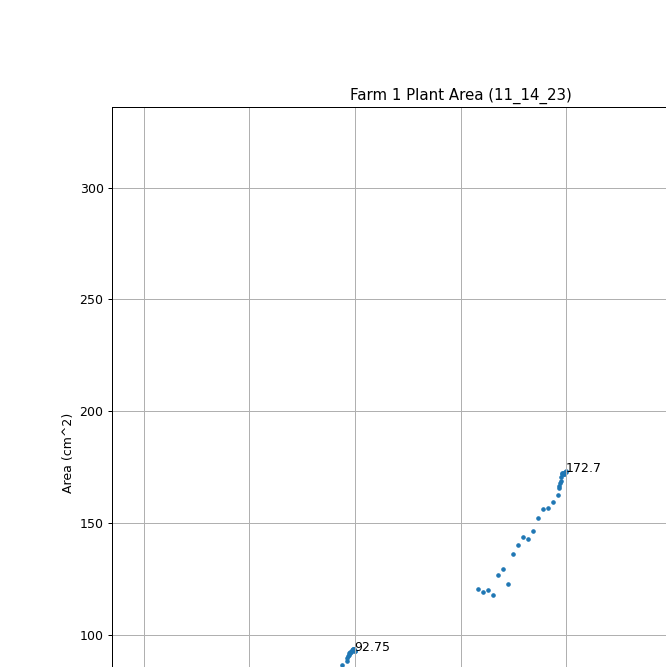

In [15]:
plot_scatter(FarmDates_11_14_23, Farm1_11_14_23, "Farm 1 Plant Area (11_14_23)")

## Create multiple linear regression model to predict growh

### Drop The First Two Columns

In [19]:
combined_farm_data = combined_farm_data.drop('Name', axis=1)
combined_farm_data = combined_farm_data.drop('Date', axis=1)

In [20]:
print(combined_farm_data)

   Red 1 Green 1 Blue 1 Intensity 1  Red 2 Green 2 Blue 2 Intensity 2    Area
0  232.0    40.0   43.0        90.0  249.0   247.0  248.0        60.0  215.43
1    153      28     42         102     22      67    162         200  329.88
2  255.0   191.0    0.0        90.0  249.0   247.0  248.0        60.0  257.69
3     22      67    162         200    232      40     43         134  228.88
4    8.0   148.0    4.0        90.0  249.0   247.0  248.0        60.0  247.87
5      7      42    108         165    153      28     42         102  414.31
6    7.0    42.0  108.0        90.0  249.0   247.0  248.0        60.0  222.32
7    7.0    42.0  108.0       165.0  232.0    40.0   43.0       134.0  305.68


### Splitting the dataset into the Training set and Test set

In [21]:
X = combined_farm_data.iloc[:, :-1].values
y = combined_farm_data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Training the Multiple Linear Regression model on the Training set

In [22]:
regressor = LinearRegression() #build the multiple linear regression Model
regressor.fit(X_train, y_train) #train the multiple linear regression model on our training set

LinearRegression()

### Predicting the Test set results

In [23]:
y_pred = regressor.predict(X_test) #y_pred is the vector of the predicted profits in the test set
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[255.29254239188663 222.32]
 [123.65812389084772 257.69]]


## Create decision tree regression model to predict growh

In [24]:
X2 = combined_farm_data.iloc[:, :-1].values
y2 = combined_farm_data.iloc[:, -1].values

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

In [25]:
regressor2 = DecisionTreeRegressor(random_state = 0)
regressor2.fit(X_train2, y_train2)

DecisionTreeRegressor(random_state=0)

In [26]:
y_pred2 = regressor2.predict(X_test2)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred2.reshape(len(y_pred2),1), y_test2.reshape(len(y_test2),1)),1))

[[305.68 222.32]
 [247.87 257.69]]


## Create random forest regression model to predict growh

In [35]:
X3 = combined_farm_data.iloc[:, :-1].values
y3 = combined_farm_data.iloc[:, -1].values

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 0)

In [36]:
scores3 = []

for a in range(1, 25):
    
    regressor3 = RandomForestRegressor(n_estimators = a, random_state = 0)
    regressor3.fit(X_train3, y_train3)
    y_pred3 = regressor3.predict(X_test3)
    np.set_printoptions(precision=2)
    scores3.append(mean_absolute_error(y_test3, y_pred3))


<IPython.core.display.Javascript object>


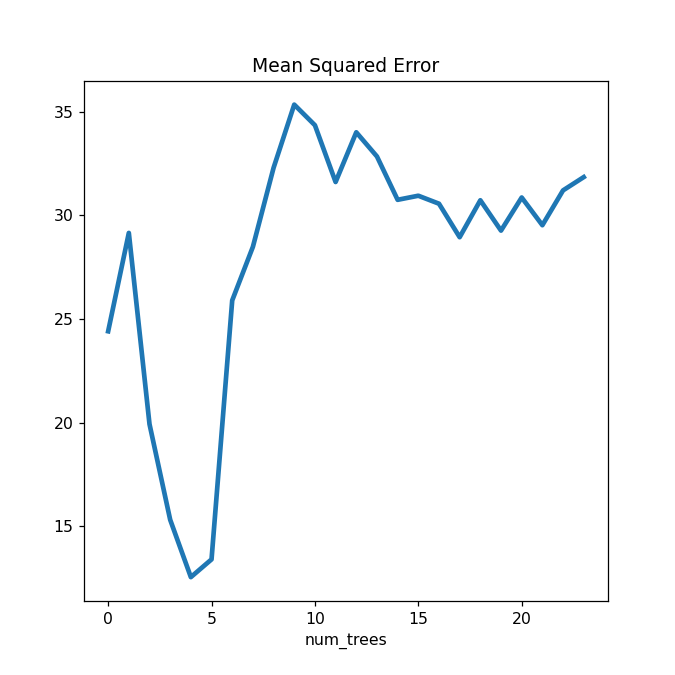

Text(0.5, 0, 'num_trees')

In [42]:
plt.figure(figsize=(6, 6))
plt.plot(scores3, linewidth=3)
plt.title('Mean Squared Error')
plt.xlabel('num_trees')

In [38]:
regressor3 = RandomForestRegressor(n_estimators = 4, random_state = 0)
regressor3.fit(X_train3, y_train3)

RandomForestRegressor(n_estimators=4, random_state=0)

In [39]:
y_pred3 = regressor3.predict(X_test3)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred3.reshape(len(y_pred3),1), y_test3.reshape(len(y_test3),1)),1))

[[226.90250000000003 222.32]
 [231.65 257.69]]


## Create Artificial Neural Network model to predict growh

In [43]:
combined_farm_data

,Red 1,Green 1,Blue 1,Intensity 1,Red 2,Green 2,Blue 2,Intensity 2,Area
0,232.0,40.0,43.0,90.0,249.0,247.0,248.0,60.0,215.43
1,153,28,42,102,22,67,162,200,329.88
2,255.0,191.0,0.0,90.0,249.0,247.0,248.0,60.0,257.69
3,22,67,162,200,232,40,43,134,228.88
4,8.0,148.0,4.0,90.0,249.0,247.0,248.0,60.0,247.87
5,7,42,108,165,153,28,42,102,414.31
6,7.0,42.0,108.0,90.0,249.0,247.0,248.0,60.0,222.32
7,7.0,42.0,108.0,165.0,232.0,40.0,43.0,134.0,305.68


In [44]:
''' Separate Target Variable and Predictor Variables'''

TargetVariable=['Area']
Predictors=['Red 1', 'Green 1', 'Blue 1', 'Intensity 1', 'Red 2', 'Green 2', 'Blue 2', 'Intensity 2'] 

In [45]:
X4=combined_farm_data[Predictors].values
y4=combined_farm_data[TargetVariable].values

In [46]:
### Sandardization of data ###
from sklearn.preprocessing import StandardScaler

PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X4)
TargetVarScalerFit=TargetVarScaler.fit(y4)

# Generating the standardized values of X and y
X4=PredictorScalerFit.transform(X4)
y4=TargetVarScalerFit.transform(y4)

In [47]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size = 0.2, random_state = 3)

### Build the ANN

In [99]:
ann = tf.keras.models.Sequential()

In [100]:
# Defining the Input layer and FIRST hidden layer, both are same!
ann.add(tf.keras.layers.Dense(units=6, input_dim=8, kernel_initializer='normal', activation='relu'))

In [101]:
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
ann.add(tf.keras.layers.Dense(units=12, kernel_initializer='normal', activation='relu'))

In [102]:
# Defining the Third layer of the model
ann.add(tf.keras.layers.Dense(units=24, kernel_initializer='normal', activation='tanh'))

In [103]:
# The output neuron is a single fully connected node
ann.add(tf.keras.layers.Dense(units=1, kernel_initializer='normal'))

In [104]:
ann.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 6)                 54        
                                                                 
 dense_24 (Dense)            (None, 12)                84        
                                                                 
 dense_25 (Dense)            (None, 24)                312       
                                                                 
 dense_26 (Dense)            (None, 1)                 25        
                                                                 
Total params: 475 (1.86 KB)
Trainable params: 475 (1.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Complie and Train the ANN

In [66]:
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [67]:
# Fitting the ANN to the Training set
output = ann.fit(X_train4, y_train4, batch_size = 20, epochs = 100, verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 751ms/step - loss: 0.5448
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 0.5374
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5311
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 0.5250
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.5188
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 0.5124
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.5054
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4978
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4894
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.4803
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.4704
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.4597
Epoch 13/100
1/1 [==============================] - 0s

In [68]:
y_pred4 = 0
y_pred4 = ann.predict(X_test4)
y_pred4 = TargetVarScalerFit.inverse_transform(y_pred4)
y_test4 = TargetVarScalerFit.inverse_transform(y_test4)
print(y_pred4)
print(y_test4)

1/1 [==============================] - 0s 102ms/step
[[248.13]
 [239.52]]
[[414.31]
 [305.68]]


## Evaluation Metrics


In [72]:
mae_1 = mean_absolute_error(y_test, y_pred)
mse_1 = mean_squared_error(y_test, y_pred)
rmse_1 = np.sqrt(mse_1)
r2_1 = r2_score(y_test, y_pred)
print("Mean Absolute Error:", mae_1)
print("Mean Squared Error:", mse_1)
print("Root Mean Squared Error:", rmse_1)
print("R-squared (R2) Score:", r2_1)

Mean Absolute Error: 83.50220925051946
Mean Squared Error: 9525.866182561955
Root Mean Squared Error: 97.60054396652693
R-squared (R2) Score: -29.457506673262642


In [73]:
mae_2 = mean_absolute_error(y_test2, y_pred2)
mse_2 = mean_squared_error(y_test2, y_pred2)
rmse_2 = np.sqrt(mse_2)
r2_2 = r2_score(y_test2, y_pred2)
print("Mean Absolute Error:", mae_2)
print("Mean Squared Error:", mse_2)
print("Root Mean Squared Error:", rmse_2)
print("R-squared (R2) Score:", r2_2)

Mean Absolute Error: 46.59
Mean Squared Error: 3522.661000000001
Root Mean Squared Error: 59.352009233049564
R-squared (R2) Score: -10.263172173418706


In [74]:
mae_3 = mean_absolute_error(y_test3, y_pred3)
mse_3 = mean_squared_error(y_test3, y_pred3)
rmse_3 = np.sqrt(mse_3)
r2_3 = r2_score(y_test2, y_pred3)
print("Mean Absolute Error:", mae_3)
print("Mean Squared Error:", mse_3)
print("Root Mean Squared Error:", rmse_3)
print("R-squared (R2) Score:", r2_3)

Mean Absolute Error: 15.311250000000015
Mean Squared Error: 349.540453125
Root Mean Squared Error: 18.69600099285941
R-squared (R2) Score: -0.11760237647666472


In [75]:
mae_4 = mean_absolute_error(y_test4, y_pred4)
mse_4 = mean_squared_error(y_test4, y_pred4)
rmse_4 = np.sqrt(mse_4)
r2_4 = r2_score(y_test4, y_pred4)
print("Mean Absolute Error:", mae_4)
print("Mean Squared Error:", mse_4)
print("Root Mean Squared Error:", rmse_4)
print("R-squared (R2) Score:", r2_4)

Mean Absolute Error: 116.16828643798829
Mean Squared Error: 15995.843447157049
Root Mean Squared Error: 126.47467512176914
R-squared (R2) Score: -4.422100677018248


### Mean Absolute Error and Root Mean Squared Error

<IPython.core.display.Javascript object>


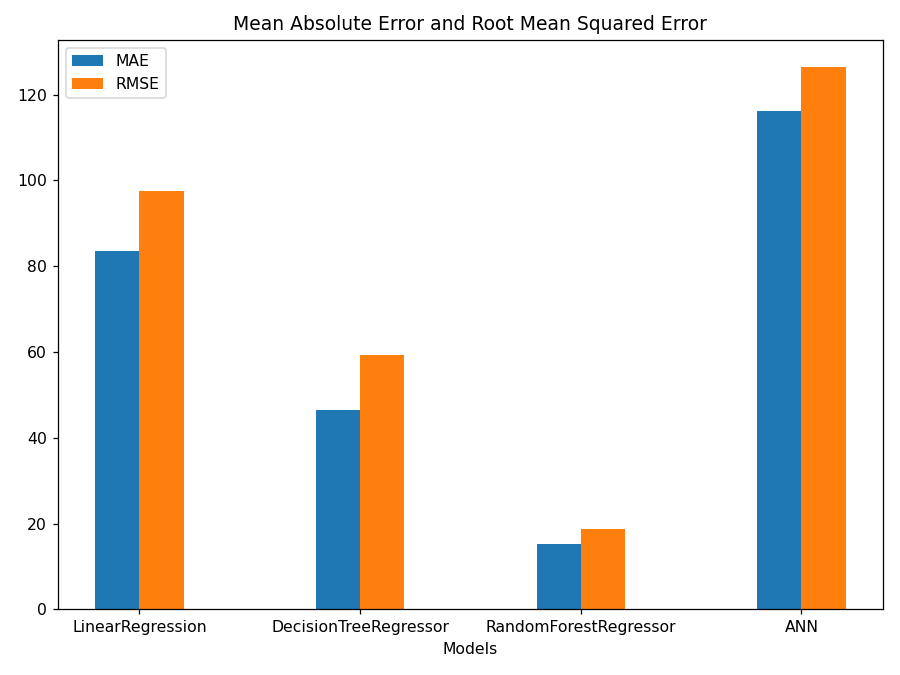

In [76]:
# Evaluation metrics for each model
mae_values = [mae_1, mae_2, mae_3, mae_4]
rmse_values = [rmse_1, rmse_2, rmse_3, rmse_4]

# Labels for the models
model_labels = ["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", "ANN"]

# Set the width of the bars
bar_width = 0.2

# Create an array of indices for the x-axis locations
indices = np.arange(len(model_labels))

# Create the grouped bar chart
plt.figure(figsize=(8, 6))
plt.bar(indices, mae_values, bar_width, label='MAE')
plt.bar(indices + 1 * bar_width, rmse_values, bar_width, label='RMSE')

# Set the x-axis labels
plt.xticks(indices + 0.5 * bar_width, model_labels)

# Add labels and legend
plt.xlabel('Models')
plt.title('Mean Absolute Error and Root Mean Squared Error')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

### Mean Square Error

<IPython.core.display.Javascript object>


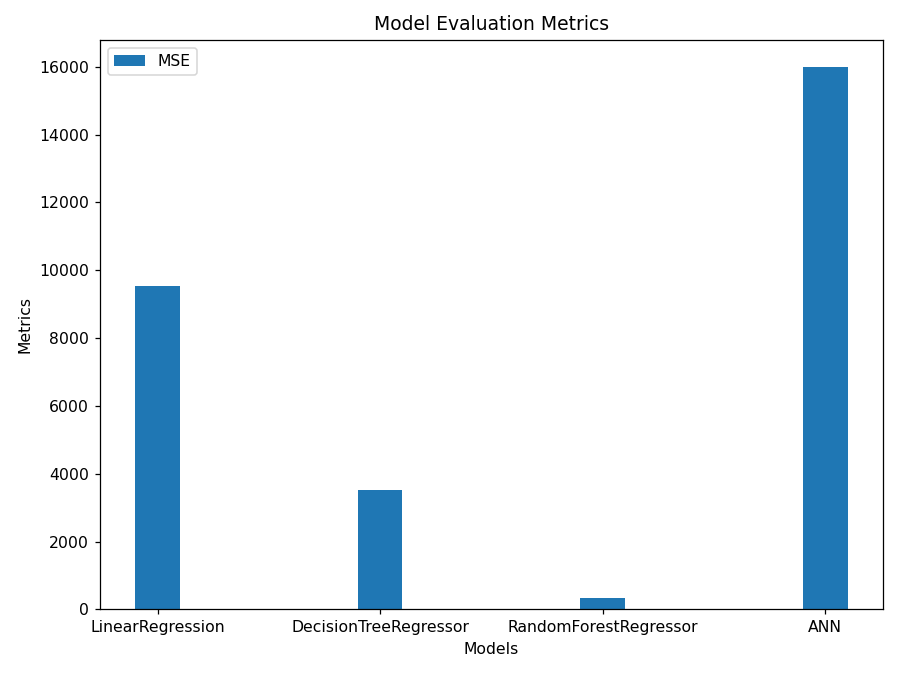

In [77]:

# Evaluation metrics for each model
mse_values = [mse_1, mse_2, mse_3, mse_4]

# Labels for the models
model_labels = ["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", "ANN"]

# Set the width of the bars
bar_width = 0.2

# Create an array of indices for the x-axis locations
indices = np.arange(len(model_labels))

# Create the grouped bar chart
plt.figure(figsize=(8, 6))
plt.bar(indices + bar_width, mse_values, bar_width, label='MSE')

# Set the x-axis labels
plt.xticks(indices + 1 * bar_width, model_labels)

# Add labels and legend
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Evaluation Metrics')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


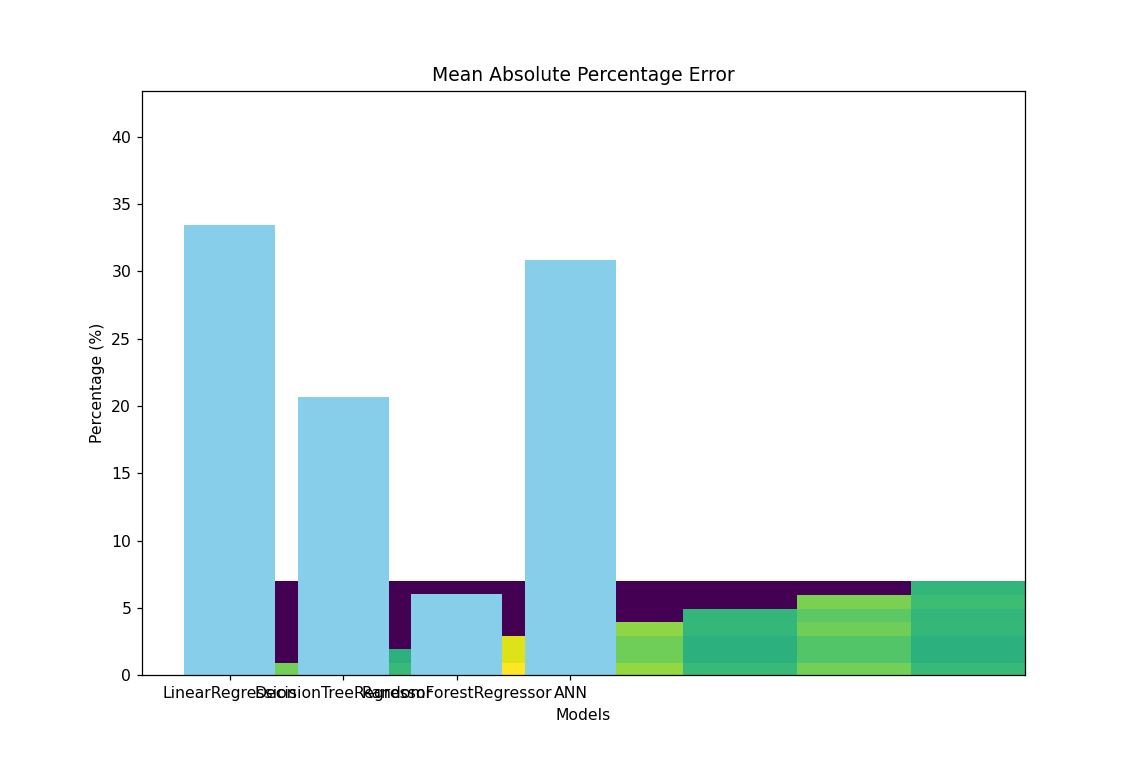

33.42197700212496 20.653141187088753 6.083191592466755 30.876416097019156


In [78]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_1 = mean_absolute_percentage_error(y_test, y_pred)
mape_2 = mean_absolute_percentage_error(y_test2, y_pred2)
mape_3 = mean_absolute_percentage_error(y_test3, y_pred3)
mape_4 = mean_absolute_percentage_error(y_test4, y_pred4)

mape_values = [mape_1, mape_2, mape_3, mape_4]
model_labels = ["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor", "ANN"]

plt.figure(figsize=(9, 6))
plt.bar(model_labels, mape_values, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Percentage (%)')
plt.title('Mean Absolute Percentage Error')
plt.ylim(0, max(mape_values) + 10)  # Adjust the y-axis range if needed
plt.show()
print(mape_1, mape_2, mape_3,mape_4 )

### Confusion Matrix for Plant Area on Random Forest

In [79]:
areas = list()
final_areas = list()
count = 0
final = 0

Channels = {'True Blue':  (22, 67, 162), 'True Red': (232, 40, 43), 
        'Hyper Red': (153, 28, 42), 'Deep Blue': (7, 42, 108),
         'Amber': (255, 191, 0), 'True Green': (8, 148, 4),
         '5k White': (249, 248, 60)}

Channels2 = {'True Blue':  (22, 67, 162), 'True Red': (232, 40, 43), 
        'Hyper Red': (153, 28, 42), 'Deep Blue': (7, 42, 108),
         'Amber': (255, 191, 0), 'True Green': (8, 148, 4),
         '5k White': (249, 248, 60)}

colors1 = ["True Blue", "True Red", "Hyper Red", "Deep Blue",
              "Amber", "True Green", "5k White"]

colors2 = ["True Blue", "True Red", "Hyper Red", "Deep Blue",
              "Amber", "True Green", "5k White"]

for color, rbg in Channels.items():
    
    while final > 0:
        areas.append(0)
        final = final - 1
    
    for color2, rbg2 in Channels2.items():
        #print(color, color2)        
        prediction3 = regressor3.predict([[rbg[0], rbg[1], rbg[2], 75, rbg2[0], rbg2[1], rbg2[2], 75]])
        areas.append(round(prediction3[0],2))
        
        

    final_areas.append(areas)
    areas = list()
    del Channels2[color]
    count = count + 1
    final = count

<IPython.core.display.Javascript object>


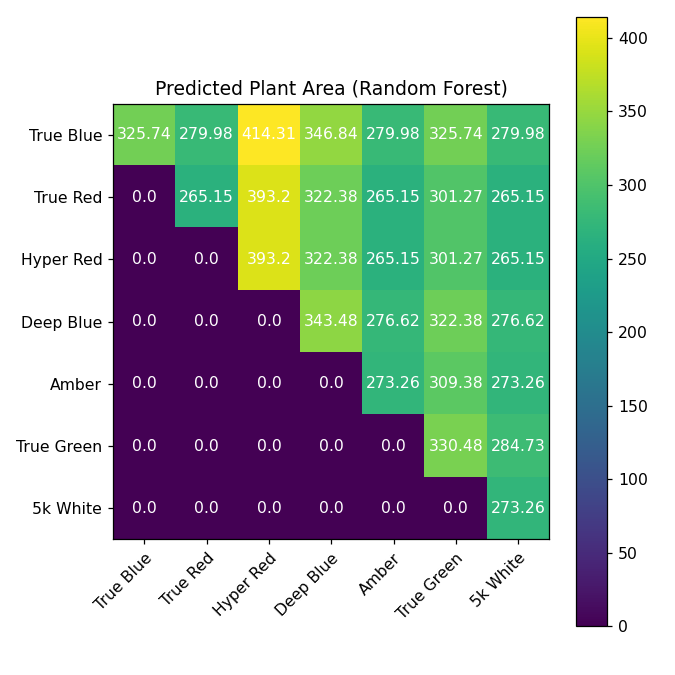

C:\Users\18155\AppData\Local\Temp\ipykernel_48068\2537051250.py:30: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



In [80]:
colors1 = ["True Blue", "True Red", "Hyper Red", "Deep Blue",
              "Amber", "True Green", "5k White"]

colors2 = ["True Blue", "True Red", "Hyper Red", "Deep Blue",
              "Amber", "True Green", "5k White"]

all_areas = np.array(final_areas)

heatmap = plt.pcolor(all_areas)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(all_areas)

# We want to show all ticks...
ax.set_xticks(np.arange(len(colors1)))
ax.set_yticks(np.arange(len(colors2)))
# ... and label them with the respective list entries
ax.set_xticklabels(colors1)
ax.set_yticklabels(colors2)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(colors1)):
    for j in range(len(colors2)):
        text = ax.text(j, i, all_areas[i, j],
                       ha="center", va="center", color="w")

plt.colorbar(heatmap)
ax.set_title("Predicted Plant Area (Random Forest)")
fig.tight_layout()
plt.show()